In [ ]:
# ToTensor() 会把 PIL Image 或 numpy.ndarray 
# 转换为形状为 (C, H, W) 且数值归一化到 [0.0, 1.0] 的 FloatTensor
# 其中 C 是通道数，H 是高度，W 是宽度

>>> 正在下载和准备数据...
>>> DataLoader 准备完毕. Batch Size: 64
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Using cpu device
Epoch 1
-------------------------------
loss: 2.302007  [    0/60000]
loss: 2.275602  [ 6400/60000]
loss: 2.276595  [12800/60000]
loss: 2.260164  [19200/60000]
loss: 2.249171  [25600/60000]
loss: 2.222799  [32000/60000]
loss: 2.222496  [38400/60000]
loss: 2.200681  [44800/60000]
loss: 2.194832  [51200/60000]
loss: 2.162045  [57600/60000]
Test Error: 
 Accuracy: 35.9%, Avg loss: 2.166326 

Epoch 2
-------------------------------
loss: 2.165763  [    0/60000]
loss: 2.160800  [ 6400/60000]
loss: 2.097802  [12800/60000]
loss: 2.103452  [19200/60000]
loss: 2.101764  [25600/60000]
loss: 2.052355  [32000/60000]
loss: 2.017766  [38400/60000]
loss: 2.026807  [44800/60000]
loss: 1.960467  [51200/60000]
loss: 1.923787  [57600/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.919995 

Epoch 3
-------------------------------
loss: 1.911981  [   

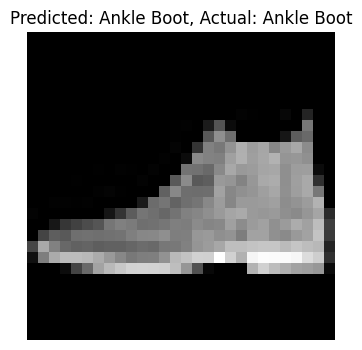

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 准备数据 (Data Preparation)
# ---------------------------------------------------------
print(">>> 正在下载和准备数据...")

# 定义 One-Hot 编码的 Lambda 函数
target_transform_fn = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
# y = 5 (代表凉鞋) 
# result = target_transform_fn(y)
# print(result)
# # 输出: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

# 下载训练集
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # 图片转为 Tensor 并归一化
    # target_transform=target_transform_fn 
    # 标准 CrossEntropyLoss 不需要 One-Hot
)

# 下载测试集
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# ---------------------------------------------------------
# 2. 创建 DataLoader (物流系统)
# ---------------------------------------------------------
batch_size = 64

# 训练集需要 Shuffle 防止过拟合
train_dataloader = DataLoader(
    training_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f">>> DataLoader 准备完毕. Batch Size: {batch_size}")

# ---------------------------------------------------------
# 3. 探索数据 (Visualization) 
# ---------------------------------------------------------
# 取出第一个 Batch 的数据
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# 标签映射表 (FashionMNIST 的类别)
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}

# ---------------------------------------------------------
# 4. 定义模型 (Model Definition)
# ---------------------------------------------------------
# 简单的全连接神经网络
# 继承 nn.Module：是 PyTorch 所有神经网络的基类（父类）
# 继承了它，你的这个类就拥有了 PyTorch 的超能力
# （比如自动求导、管理参数、移动到 GPU 等）。
# 记住：写模型，必继承 nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self): # 创建实例时 调用 全连接层（Linear）只吃一维向量
        super(NeuralNetwork, self).__init__() # 调用父类的构造函数
        self.flatten = nn.Flatten() # 将 28x28 的图像展平成 784 维向量
        self.linear_relu_stack = nn.Sequential( # 顺序容器 按顺序组合多个层
            nn.Linear(28*28, 512), # 全连接层（线性层）
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10) # 输出 10 个类别的分数 logits
        )

    def forward(self, x):# 前向传播
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device)

# ---------------------------------------------------------
# 5. 训练与评估函数
# ---------------------------------------------------------
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # 切换到训练模式 
    for batch, (X, y) in enumerate(dataloader): # X图片tensor，y是标签
        X, y = X.to(device), y.to(device) 
# for 循环会自动不断调用 next，
# 直到把 DataLoader 里所有的数据（60000张图）全部取完一遍
        # 1. 计算预测值 不写 model.forward()，直接调用 model(X)
        pred = model(X) # 前向传播 得到预测值 pred logits [batch_size, 10]
        # 2. 计算损失
        loss = loss_fn(pred, y)

        # 3. 反向传播 (Backpropagation)
        optimizer.zero_grad() # 清空梯度
        loss.backward()       # 计算梯度
        optimizer.step()      # 更新参数

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # 切换到评估模式
    test_loss, correct = 0, 0
    
    with torch.no_grad(): # 评估不需要计算梯度，节省内存
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 统计预测正确的数量
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# 6. 开始运行 (Execution)
# 用Crossentrophy 神经网络的最后一层不要加 Softmax
loss_fn = nn.CrossEntropyLoss() # 多分类标准损失函数 loss = loss_fn(pred, y)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 随机梯度下降

epochs = 3 # 为了演示，只训练 3 轮
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

# ---------------------------------------------------------
# 7. 预测结果可视化 (Visualization)
# ---------------------------------------------------------
model.eval()
x, y = test_data[0][0], test_data[0][1] # 取出测试集第一张图
# dataset[i] 返回 (image, label) 元组 如果有 transform 则 image 已经是 Tensor 如：(Tensor[1, 28, 28], 9)
with torch.no_grad():
    x = x.to(device) # 把图片数据也搬到 GPU 上
    pred = model(x.unsqueeze(0)) # 增加 batch 维度 [1, 1, 28, 28]
    predicted, actual = labels_map[pred.argmax(1).item()], labels_map[y]

# matplotlib 运行在 CPU 上，只能读取内存（RAM）里的数据
plt.figure(figsize=(4, 4))
plt.title(f"Predicted: {predicted}, Actual: {actual}")
# 将 Tensor 转回 CPU 并去除多余维度用于绘图
plt.imshow(x.cpu().squeeze(), cmap="gray") 
plt.axis("off")
plt.show()

GPU (Graphics Processing Unit)：是芯片，正方形硅片，负责计算。显卡的大脑。

显卡 (Graphics Card)：是整块板卡，包含了 GPU 芯片、显存（VRAM）、风扇、供电电路等。

>>> 正在下载和准备数据...
>>> DataLoader 准备完毕. Batch Size: 64
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Using cuda device
Epoch 1
-------------------------------
loss: 2.305996  [    0/60000]
loss: 0.523260  [ 6400/60000]
loss: 0.561044  [12800/60000]
loss: 0.539955  [19200/60000]
loss: 0.314743  [25600/60000]
loss: 0.315579  [32000/60000]
loss: 0.463621  [38400/60000]
loss: 0.474558  [44800/60000]
loss: 0.409294  [51200/60000]
loss: 0.598428  [57600/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.436800 

Epoch 2
-------------------------------
loss: 0.548102  [    0/60000]
loss: 0.264902  [ 6400/60000]
loss: 0.280259  [12800/60000]
loss: 0.244279  [19200/60000]
loss: 0.411575  [25600/60000]
loss: 0.449766  [32000/60000]
loss: 0.252370  [38400/60000]
loss: 0.233367  [44800/60000]
loss: 0.374926  [51200/60000]
loss: 0.281075  [57600/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.416713 

Epoch 3
-------------------------------
loss: 0.321327  [  

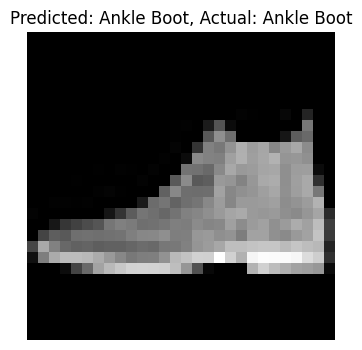

In [4]:
# 纯代码
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

# ==========================================
# 1. 准备数据 (Data Preparation)
# ==========================================
print(">>> 正在下载和准备数据...")

# 演示用：定义 One-Hot 编码 (实际训练用的 CrossEntropyLoss 不需要此转换，故仅作演示)
# 逻辑：创建一个全0向量，在标签对应的索引位置填入1
target_transform_fn = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

# 下载训练集
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # 核心：将图片转换为 Tensor 并归一化 (0~1)
)

# 下载测试集
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# ==========================================
# 2. 创建 DataLoader (数据加载器)
# ==========================================
batch_size = 64

# 训练集开启 shuffle=True，打乱数据防止过拟合
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
# 测试集不需要 shuffle
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f">>> DataLoader 准备完毕. Batch Size: {batch_size}")

# 探索一下数据形状
# next(iter(...)) 模拟从加载器中取出一批数据
# 代码执行完后，因为没有变量引用这个临时迭代器，
# Python 的垃圾回收机制就会把它销毁
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}") # [64, 1, 28, 28]
print(f"Labels batch shape: {train_labels.size()}")   # [64]

# 标签映射表
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}

# ==========================================
# 3. 定义模型 (Model Definition)
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Flatten: 将 2D 图像 (28x28) 展平为 1D 向量 (784)
        self.flatten = nn.Flatten()
        
        # Sequential: 定义一个有序的层容器 (Linear -> ReLU -> Linear ...)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # 输入 784，输出 512
            nn.ReLU(),             # 非线性激活
            nn.Linear(512, 512),   # 隐藏层
            nn.ReLU(),
            nn.Linear(512, 10)     # 输出层：10个类别的原始分数 (logits)
        )

    def forward(self, x):
        # 1. 展平
        x = self.flatten(x)
        # 2. 通过网络层管道
        logits = self.linear_relu_stack(x) # 得到输出 logits
        return logits

# 实例化模型并移动到设备(GPU/CPU)
model = NeuralNetwork().to(device)

# ==========================================
# 4. 定义训练与测试逻辑
# ==========================================
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # 开启训练模式 (启用 Dropout/BatchNorm 等)
    
    # 枚举 DataLoader，这里会遍历所有数据
    # DataLoader 有属性 .dataset 和 batch_size
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # --- 核心步骤 ---
        # 1. 前向传播：调用 model(X) 自动触发 forward
        pred = model(X) 
        
        # 2. 计算损失
        loss = loss_fn(pred, y)

        # 3. 反向传播
        optimizer.zero_grad() # 清空旧梯度
        loss.backward()       # 计算新梯度
        optimizer.step()      # 更新参数

        # 打印进度
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # 开启评估模式
    test_loss, correct = 0, 0
    
    with torch.no_grad(): # 评估时不计算梯度，节省显存
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # 形状: [batch_size, 10] 64 张图在 10 个类别上的得分
            test_loss += loss_fn(pred, y).item()
            # 统计准确率: argmax(1) 找到分数最高的类别索引
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
# pred.argmax(1) == y 是64个布尔值组成的张量，表示每张图是否预测正确 [1.,0.,1.,...]
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# ==========================================
# 5. 开始执行 (Execution)
# ==========================================
# 损失函数: CrossEntropyLoss 包含了 LogSoftmax 和 NLLLoss
# 它可以处理未归一化的 logits，不需要手动加 Softmax
loss_fn = nn.CrossEntropyLoss()

# 优化器: SGD (随机梯度下降) 不如 Adam 快：能自适应调整步长
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

# ==========================================
# 6. 预测结果可视化 (Visualization)
# ==========================================
model.eval()
# 取测试集第一张图 (索引 [0] 返回 (image, label))
x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    x = x.to(device)
    # 模型需要 batch 维度，所以用 unsqueeze(0) 将 [1, 28, 28] 变成 [1, 1, 28, 28]
    pred = model(x.unsqueeze(0))
    
    # 获取预测结果 (分数最高的索引)
    predicted_idx = pred.argmax(1).item()
    predicted_name = labels_map[predicted_idx]
    actual_name = labels_map[y]

# 绘图 (必须将 Tensor 转回 CPU) 在神经网络中，通常将数据标准化到 [-1, 1]（均值为0）会让收敛速度快很多
plt.figure(figsize=(4, 4))
plt.title(f"Predicted: {predicted_name}, Actual: {actual_name}")
plt.imshow(x.cpu().squeeze(), cmap="gray") 
plt.axis("off")
plt.show()

>>> 正在下载和准备数据...
Using cuda device
Epoch 1
-------------------------------
loss: 2.339785  [    0/60000]
loss: 0.422750  [ 6400/60000]
loss: 0.527896  [12800/60000]
loss: 0.395326  [19200/60000]
loss: 0.324069  [25600/60000]
loss: 0.423866  [32000/60000]
loss: 0.304834  [38400/60000]
loss: 0.431969  [44800/60000]
loss: 0.344156  [51200/60000]
loss: 0.397575  [57600/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.400423 

Epoch 2
-------------------------------
loss: 0.429801  [    0/60000]
loss: 0.511544  [ 6400/60000]
loss: 0.310708  [12800/60000]
loss: 0.522797  [19200/60000]
loss: 0.335812  [25600/60000]
loss: 0.257368  [32000/60000]
loss: 0.302584  [38400/60000]
loss: 0.374253  [44800/60000]
loss: 0.223253  [51200/60000]
loss: 0.490825  [57600/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.409849 

Epoch 3
-------------------------------
loss: 0.368415  [    0/60000]
loss: 0.453404  [ 6400/60000]
loss: 0.336652  [12800/60000]
loss: 0.266087  [19200/60000]
loss: 0.251529  [2560

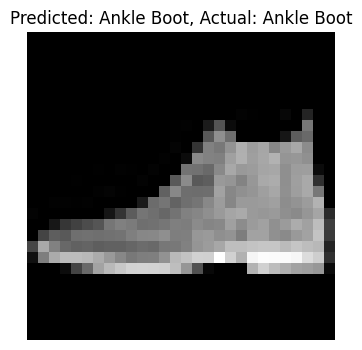

In [3]:
# 改进版
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # 引入 transforms
import matplotlib.pyplot as plt

# ==========================================
# 改进点 1: 数据预处理 (加入 Normalize)
# ==========================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # 将 [0, 1] 变为 [-1, 1]，加速收敛
])

print(">>> 正在下载和准备数据...")
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transform
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transform
)

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 模型结构保持不变 (全连接层对于这个任务够用了，虽然不如 CNN)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()

# ==========================================
# 改进点 2: 换成 Adam 优化器 (它是 SGD 的升级版)
# ==========================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# ==========================================
# 改进点 3: 增加 Epochs (让模型多学几遍)
# ==========================================
epochs = 10 # 建议增加到 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

# 可视化部分
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot",
}
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    predicted_idx = pred.argmax(1).item()
    predicted_name = labels_map[predicted_idx]
    actual_name = labels_map[y]

plt.figure(figsize=(4, 4))
plt.title(f"Predicted: {predicted_name}, Actual: {actual_name}")
# 因为做了 Normalize，显示时最好反归一化一下，不然图片看起来黑乎乎的
img_show = x.cpu().squeeze() * 0.5 + 0.5 
plt.imshow(img_show, cmap="gray") 
plt.axis("off")
plt.show()

In [1]:
# 检查gpu是否可用
import torch
from torch import nn
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")


GPU is available.


>>> 运行设备: cuda
>>> 开始训练...
Epoch 1/5 | Loss: 0.5545 | Test Acc: 87.14%
Epoch 2/5 | Loss: 0.3685 | Test Acc: 88.72%
Epoch 3/5 | Loss: 0.3193 | Test Acc: 90.08%
Epoch 4/5 | Loss: 0.2864 | Test Acc: 89.60%
Epoch 5/5 | Loss: 0.2618 | Test Acc: 91.21%

>>> 模型参数已保存至: cnn_fashion_mnist.pth
>>> 模型加载成功，准备推断...


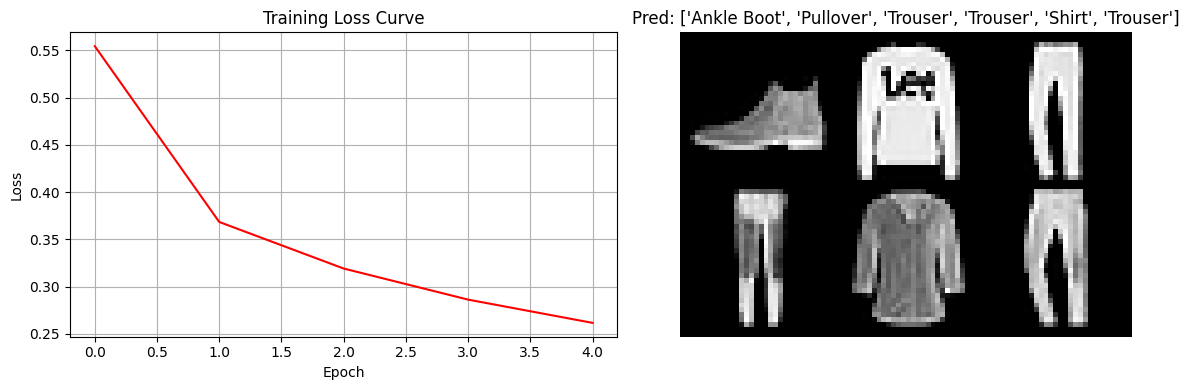

In [ ]:
# FashionMNIST 分类项目 (CNN版)
import torch
import torch.nn as nn
import torch.nn.functional as F  # 科研常用的函数式接口
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# ==========================================
# 0. 超参数配置 (Configuration)
# ==========================================
BATCH_SIZE = 64
LEARNING_RATE = 0.001  # Adam 通常用 1e-3 or 3e-4
EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# 全局常量 如果一个变量在程序运行期间不应该被修改，就把它全大写。如超参数

print(f">>> 运行设备: {DEVICE}")

# ==========================================
# 1. 自定义数据集类 (模拟读取本地数据)
# ==========================================
# 虽然这里 wrap 了官方数据，但你要学会这个结构，
# 以后读本地文件夹里的图片就靠重写这个类。
class MyCustomDataset(Dataset):
    def __init__(self, is_train=True):
        # 预处理：转 Tensor + 标准化
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) # 将像素 减均值，除以标准差 归一化到 [-1, 1] 加速收敛
        ])
        # 这里模拟下载/读取数据
        self.data_source = datasets.FashionMNIST(
            root="data", train=is_train, download=True, transform=self.transform
        ) # 是个 Dataset 对象 self.data_source[0] 返回 (Tensor[1,28,28], label)

# self.data_source 是 实例化了一个FashionMNIST 的对象，
# 类型是datasets.FashionMNIST
# 此时数据仍为原始的0-255，Transform 真正发生，
# 是执行 self.data_source[idx]，即 __getitem__ 触发时
# 调用 datasets.FashionMNIST 这个类里写好的 __getitem__(idx) 方法
# 两个类的 __getitem__ 方法是嵌套调用的,
# 对一个对象写 [idx] 时，就是调用这个对象的 __getitem__ 方法


# 原始文本存在硬盘里，只有在训练的那一刻，
# 它才会被 Tokenizer 变成数字 ID，然后丢给 GPU
    def __len__(self):
        return len(self.data_source)
# 魔法方法 对一个对象使用 len() 函数时，应该返回什么

# 定义了使用下标索引（比如 dataset[5]）时，应该返回什么
    def __getitem__(self, idx):
        # 必须返回 (img, label)
        return self.data_source[idx]
        # 嵌套！这个 idx 会传给 datasets.FashionMNIST 里的 __getitem__
        # 等价于 return self.data_source.__getitem__(idx)
        # 官方 FashionMNIST 类的 __getitem__ 函数会检查transform：img = self.transform(img)
train_dataset = MyCustomDataset(is_train=True)
test_dataset = MyCustomDataset(is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 2. 定义 CNN 模型 (进阶架构)
# ==========================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 特征提取层 (Convolutional Layers)
        # Conv2d: 输入1通道(灰度), 输出32通道(特征图), 卷积核3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2池化，尺寸减半
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # 分类层 (Fully Connected Layers)
        # 经过两次 pool(28->14->7), 最终特征图大小 7x7, 通道 64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5) # 随机丢弃 50% 神经元，防过拟合
        self.fc2 = nn.Linear(128, 10)  # 输出10类

    def forward(self, x):
        # 卷积 -> 激活 -> 池化
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        
        # 展平: [Batch, 64, 7, 7] -> [Batch, 3136]
        x = x.view(-1, 64 * 7 * 7) 
        
        # 全连接 -> 激活 -> Dropout -> 输出
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # 仅在训练时生效
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

# ==========================================
# 3. 训练与评估逻辑 (带记录功能)
# ==========================================
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train() # 启用 Dropout/BatchNorm
    running_loss = 0.0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 返回本轮平均 Loss
    return running_loss / len(dataloader)

def evaluate(dataloader, model):
    model.eval() # 关闭 Dropout
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            # pred.data.max(1, keepdim=True)[1] 等价于 argmax(1)
            predicted = pred.argmax(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

# ==========================================
# 4. 主循环 (Training Loop)
# ==========================================
# 损失函数 & 优化器 (Adam 是重点)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_history = [] # 记录Loss用于画图
acc_history = []  # 记录准确率

print(">>> 开始训练...")
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
    test_acc = evaluate(test_loader, model)
    
    loss_history.append(train_loss)
    acc_history.append(test_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Test Acc: {test_acc:.2f}%")

# ==========================================
# 5. 模型保存与加载 (实战必备)
# ==========================================
# 保存
save_path = "cnn_fashion_mnist.pth"
torch.save(model.state_dict(), save_path)
print(f"\n>>> 模型参数已保存至: {save_path}")

# 加载测试 (模拟实际推断场景)
new_model = SimpleCNN().to(DEVICE)
new_model.load_state_dict(torch.load(save_path, weights_only=True))
new_model.eval()
print(">>> 模型加载成功，准备推断...")

# ==========================================
# 6. 可视化分析 (Visualization)
# ==========================================
plt.figure(figsize=(12, 4))

# 图1: 训练 Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='red')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# 图2: 实际预测结果
# 从测试集随机取 6 张图
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:6].to(DEVICE)
labels = labels[:6]

preds = new_model(images).argmax(1).cpu() # 预测
images = images.cpu() # 移回CPU画图

labels_map = {0:"T-Shirt", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat",
              5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}

plt.subplot(1, 2, 2)
# 反归一化: (img * 0.5) + 0.5 -> 恢复到 [0, 1] 用于显示
grid_img = (images * 0.5) + 0.5
# 拼接成网格 (H, W) -> (C, H, W)
from torchvision.utils import make_grid
grid_img = make_grid(grid_img, nrow=3, padding=2)
plt.imshow(grid_img.permute(1, 2, 0).squeeze()) # (C,H,W) -> (H,W,C)
plt.title(f"Pred: {[labels_map[k.item()] for k in preds]}")
plt.axis('off')

plt.tight_layout()
plt.show()

**NLP**  
分词 (Tokenization): 把句子切成字，并查字典变成数字 ID。

例子： "我爱NLP" -> ["我", "爱", "NLP"] -> [23, 5, 99]

词嵌入 (Embedding): 把数字 ID 变成一串有意义的向量（数字列表）。

这是 NLP 的魔法。ID 23 只是个编号，但向量 [0.1, 0.9, -0.2...] 可以包含语义。比如 "猫" 和 "狗" 的向量在空间里离得很近。

编码器 (Encoder/Model): 比如代码里的 LSTM，它负责“阅读”这些向量，联系上下文，提取这句话的特征。

分类头 (Head): 根据特征输出结果（比如是积极还是消极）

In [8]:
# 假设 batch 是刚才那个样子：一个列表，里面装着两个样本
batch = [
    ("句子1的数据", "标签1"),
    ("句子2的数据", "标签2"),
    ("句子3的数据", "标签3")
]

# 我们想要把所有句子放在一堆，所有标签放在一堆
# zip(*batch) 就是做这个的
inputs, labels = zip(*batch)

print("Inputs:", inputs)
# 输出: ('句子1的数据', '句子2的数据', '句子3的数据')

print("Labels:", labels)
# 输出: ('标签1', '标签2', '标签3')

Inputs: ('句子1的数据', '句子2的数据', '句子3的数据')
Labels: ('标签1', '标签2', '标签3')


>>> 词表大小: 60
>>> 'NLP' 的 ID 是: 4
>>> Input Batch Shape: torch.Size([2, 6])

>>> 开始训练...
Epoch 10, Loss: 0.0160
Epoch 20, Loss: 0.0026
Epoch 30, Loss: 0.0015
Epoch 40, Loss: 0.0010
Epoch 50, Loss: 0.0007


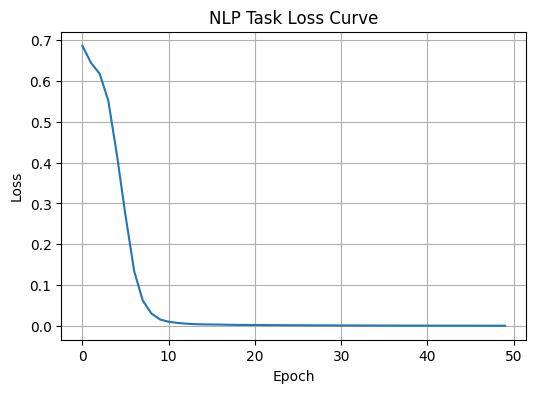


>>> 测试预测:
句子: 'PyTorch真好用' 
 -> 积极概率: 0.9994 (判断为: 积极)
句子: '代码全是Bug' 
 -> 积极概率: 0.0009 (判断为: 消极)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence # 用于对齐不同长度序列 处理长短不一的句子
import matplotlib.pyplot as plt
import numpy as np

# Sentiment Analysis 项目 (LSTM版) LSTM (长短期记忆网络) 
# 有时间顺序，必须读完上文才能读下文。如果句子太长（比如 500 个字），读到最后可能就把开头的字给忘了
# BERT (基于 Transformer 的双向编码器) 不是一个字一个字读，而是一睁眼就把整句话同时看完了
# 没有时间顺序，关注上下文关系，效果比 LSTM 强很多，但是非常吃显卡，训练慢，代码极其复杂

# 0. 配置与模拟数据 (Data Preparation)
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2 # 一次训练给模型看几句话
EMBEDDING_DIM = 8 # 每个字变成一个长度为8的向量 数组
HIDDEN_DIM = 16   # LSTM 隐藏层神经元数量 LSTM 的记忆容量，数值越大,能记住的信息越复杂，但也越容易过拟合

# 模拟原始数据 (文本, 标签) 
# 1 = 积极 (Positive), 0 = 消极 (Negative) 
raw_data = [
    ("我爱NLP", 1),
    ("PyTorch很强", 1),
    ("机器学习很有趣", 1),
    ("这个模型太差了", 0),
    ("跑代码报错很烦", 0),
    ("显存又不够了", 0),
    ("训练速度太慢", 0),
    ("大模型改变世界", 1),
    ("入门真的好难", 0),
    ("坚持学习会有收获", 1)
]

# ==========================================
# 1. 核心组件：Tokenizer (分词器)
# ==========================================
# 作用：维护 字符 <-> ID 的映射关系
class SimpleTokenizer:
    def __init__(self, data):
        # 两个特殊Token：ID 不是标签
        # <PAD>: 填充位，用于补齐长度，ID通常为0,如别的句子10个字，你只有2个字，后面8个位置填0
        # <UNK>: 未知字符，遇到没见过的字就用这个
        self.word2id = {"<PAD>": 0, "<UNK>": 1}
        self.id2word = {0: "<PAD>", 1: "<UNK>"}
        
        # 扫描数据 建立词表 属于__init__的一部分
        for text, _ in data: # 遍历每个 (文本, 标签) 元组
            for char in text: # 遍历文本中的每个字
                if char not in self.word2id: # 如果字还没见过
                    new_id = len(self.word2id) # 就分配一个新 ID
                    self.word2id[char] = new_id # 记入字典：字 -> ID
                    self.id2word[new_id] = char
    
    def encode(self, text):
        # 把文字变成数字 ID 列表
        return [self.word2id.get(char, 1) for char in text] # 遇到没见过的字用 ID 1 (<UNK>)
    
    def __len__(self):
        return len(self.word2id)

# 初始化分词器
tokenizer = SimpleTokenizer(raw_data)
print(f">>> 词表大小: {len(tokenizer)}")
print(f">>> 'NLP' 的 ID 是: {tokenizer.word2id['N']}")

# ==========================================
# 2. 定义 Dataset (和之前学的逻辑一样)
# ==========================================
class TextDataset(Dataset):# 继承 Dataset 类
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, label = self.data[idx]
        # 在这里把文本转成数字索引 (Tensor)
        input_ids = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        label = torch.tensor(label, dtype=torch.float) #二分类通常用float配合BCELoss ID是整数 要做计算，浮点数更精准
        return input_ids, label

# ==========================================
# 3. 核心难点：Collate Function (对齐)
# ==========================================
# 作用：DataLoader 取出的一个 batch 里，句子长度不一样（3个字、5个字）。
# 必须把它们“右对齐”，短的补 0。
def collate_fn(batch):
    # batch 是一个列表，里面是 [(input_ids, label), (input_ids, label), ...]
    # 如 batch为 [
    #   (tensor([2, 3, 4, 5, 6]), tensor(1.0)),  # 第1句话的ID和标签
    #   (tensor([7, 8, 9]),       tensor(0.0))   # 第2句话的ID和标签
    # ]
    
    # # zip(*batch) 是个解压操作，把所有的 input_ids 放在一起，所有的 labels 放在一起
    inputs, labels = zip(*batch)
    
    # 核心函数 pad_sequence: 自动把 tensor 列表补齐 
    # 如果有两个句子，分别是 [2,5,7] 和 [3,4]，pad_sequence 会把它们变成：
    # [[2, 5, 7],
    #  [3, 4, 0]]
    # batch_first=True 输出形状: [Batch_Size, Max_Length] 比如 [2, 3]
    # padding_value=0 用 0 来填充
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    # 假设第一句是 [2, 3, 4]，第二句是 [5]。补齐后（padding_value=0）：
    #     [
    #   [2, 3, 4],  # 第一句本来就长，不动
    #   [5, 0, 0]   # 第二句短，后面补两个0，强行跟第一句一样长
    # ]

    labels = torch.stack(labels) # 把标签列表变成一个张量，如：[tensor(1.0), tensor(0.0)] 变成 tensor([1.0, 0.0])
    return inputs_padded, labels

# 创建 DataLoader
dataset = TextDataset(raw_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn) # 对齐函数

# 验证一下形状 (非常重要！)
# 随便取一个 batch 看看
sample_input, sample_label = next(iter(dataloader))
print(f">>> Input Batch Shape: {sample_input.shape}") 
# 比如 [2, 7] 表示 batch_size=2，当前这批数据最长的句子是 7 个字
# 短的句子后面会自动全是 0

# ==========================================
# 4. 定义 LSTM 模型 (NLP 经典架构)
# ==========================================
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentLSTM, self).__init__()
        
        # 1. Embedding层: 把 ID [2, 5] 变成向量 [[0.1...], [0.8...]] 词向量层
        # padding_idx=0: 告诉模型 ID为0 的是填充物，不要计算它的梯度，直接输出0
        # vocab_size: 词表大小（有多少个字）。
        # embedding_dim: 每个字变多长（这里是8）。
        # padding_idx=0: 告诉模型 ID为0 的是废物，不要去学它，保持为0。
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0) # 词向量层 如100行 x 8列 的表格~开始表格中数字是随机的
        
        # 2. LSTM层: 处理序列信息 默认 num_layers=1
        # batch_first=True: 输入格式是 [batch, seq_len, feature]
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        
        # 3. 全连接层: 把 LSTM 的输出压缩成 1 个数值 (0~1之间) Fully Connected Layer (全连接层)。在 PyTorch 里叫 nn.Linear
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid() # 它把全连接层输出的任意数值，强行压缩到 0~1 之间，代表概率
    def forward(self, x):
        # x 形状: [batch_size, max_seq_len] 每个 Batch 的长度取决于那个 Batch 里最长的句子是谁
        
        # Step 1: 查表
        embeds = self.embedding(x) # ID 变向量 输入 ID 5 时，它就去查表格的第 5 行，把那 8 个数字返回给你~ 表格里的数字，会随着训练不断修改（学习），最后变得有意义
        # embeds 形状: [2, 7, 8] (batch, seq, embed_dim)
        
        # Step 2: 丢进 LSTM
        # LSTM 返回 (output, (h_n, c_n))
        # output 是所有时刻的输出，h_n 是最后一个时刻的“记忆”
        # 我们做分类，通常只需要最后一个时刻的记忆 h_n
        _, (h_n, _) = self.lstm(embeds)
        # h_n 形状: [1, 2, 16] (num_layers, batch, hidden)
        
        # 取掉第一维
        last_hidden = h_n.squeeze(0) # [2, 16]
        
        # Step 3: 分类
        out = self.fc(last_hidden) # [2, 1] 比如 [[0.3], [0.7]] tensor
        return self.sigmoid(out).squeeze(1) # [2] 要一维数组 比如 [0.3, 0.7] tensor

model = SentimentLSTM(len(tokenizer), EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)

# ==========================================
# 5. 训练逻辑
# ==========================================
criterion = nn.BCELoss() # 二分类交叉熵 (Binary Cross Entropy)
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []
epochs = 50

print("\n>>> 开始训练...")
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in dataloader:  
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs) # 前向传播 会自动执行 model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    losses.append(epoch_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}")

# ==========================================
# 6. 可视化与预测
# ==========================================
# 画 Loss 曲线
plt.figure(figsize=(6, 4))
plt.plot(losses, label='Training Loss')
plt.title("NLP Task Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 预测新句子
def predict(text):
    model.eval()
    with torch.no_grad():
        # 1. 也是要先 Tokenize
        ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(DEVICE)
        # 2. 也是要模型预测
        prob = model(ids).item()
        print(f"句子: '{text}' \n -> 积极概率: {prob:.4f} (判断为: {'积极' if prob>0.5 else '消极'})")

print("\n>>> 测试预测:")
predict("PyTorch真好用")
predict("代码全是Bug")

关于上文的for inputs, labels in dataloader:  
假设 BATCH_SIZE = 2（一次拿2个），DataLoader 随机抽到了这俩倒霉蛋：

句子A："我爱NLP" （ID: [2, 3, 4]，长度3） -> 标签 1

句子B："机器学习很有趣" （ID: [5, 6, 7, 8, 9, 10, 11]，长度7） -> 标签 1

这时候，collate_fn 把它俩对齐，inputs 和 labels 就会变成这样：

inputs (形状: [2, 7])
它是一个二维矩阵（长方形）。

行：代表第几个样本（Batch维度）。

列：代表句子里的字（Sequence维度）。

tensor([  
  [2, 3, 4, 0, 0, 0, 0],  # 第1行：句子A。后面补了4个0，强行撑到7这么长  
  [5, 6, 7, 8, 9, 10, 11] # 第2行：句子B。它是全场最长，决定了宽度是7  
])

0 就是 <PAD>

labels (形状: [2])  
它是一个一维向量（一条线）:tensor([1., 1.])

张量的转化：  
.item(): 仅限于只有一个元素的张量，把它转成 Python 的数字（float 或 int）。

torch.tensor([0.5]).item() -> 0.5 (Python 原生浮点数)

.tolist(): 把张量转成普通的 Python 列表。

.numpy(): 把张量转成 NumPy 数组。

训练前model.embedding.weight: Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7364, -0.1869,  1.3803,  2.0505, -1.0311, -0.2584, -0.0097,  0.2835],
        [-0.1734,  1.1020,  1.8065,  0.7444,  1.5258,  0.0395, -0.7798,  2.0147],
        [-0.2781,  1.3581,  0.2810,  0.8098, -0.9130,  0.6760, -1.2592,  0.4296],
        [ 0.1554,  1.7779, -1.0475, -1.5261, -0.1884, -0.4726,  0.7958, -1.0212],
        [ 1.4464,  0.4955,  1.4323, -0.1295, -0.8387, -1.8160, -0.2951, -0.6427],
        [ 0.3008, -0.8512,  1.7611,  0.1669,  1.2089, -0.0528, -1.8649,  1.1282],
        [ 0.9589,  0.2790,  0.5419,  1.4428, -0.1578,  0.9923,  0.7551,  0.3390],
        [ 0.2867, -0.0398, -0.0995, -1.3286, -0.6569,  0.1055, -0.2616,  2.8696],
        [ 0.0382,  0.5585,  0.5892,  0.3663, -0.5182, -0.3362, -0.7834, -0.5218],
        [ 0.1255,  0.0202, -0.0325,  0.1401, -0.8961, -0.0544, -0.0115,  0.5827],
        [ 1.2808, -0.2420,  0.7754,  1.3339, -1.6

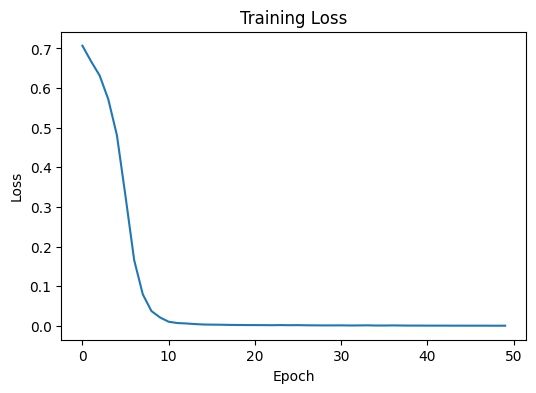

'PyTorch真好用' -> Positive Prob: 0.9971 (Positive)
'代码全是Bug' -> Positive Prob: 0.9953 (Positive)
训练后model.embedding.weight: Parameter containing:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 7.3636e-01, -1.8686e-01,  1.3803e+00,  2.0505e+00, -1.0311e+00,
         -2.5838e-01, -9.6937e-03,  2.8349e-01],
        [ 4.0025e-02,  9.2858e-01,  1.9925e+00,  9.7091e-01,  1.3042e+00,
          1.2389e-01, -1.0111e+00,  1.8502e+00],
        [-5.5485e-02,  1.1822e+00,  4.0481e-01,  1.0326e+00, -1.1373e+00,
          6.5299e-01, -1.4896e+00,  2.1301e-01],
        [ 3.7907e-01,  1.5518e+00, -1.2232e+00, -1.3005e+00, -4.1585e-01,
         -3.6113e-01,  5.5940e-01, -1.2450e+00],
        [ 1.5674e+00,  3.2069e-01,  1.1949e+00,  9.3003e-02, -1.0636e+00,
         -1.6923e+00, -5.2487e-01, -8.1240e-01],
        [ 5.3436e-01, -1.0035e+00,  1.5734e+00,  4.0598e-01,  9.6276e-01,
          8.5546e-02, -2.1200e+00,  8.9404e-

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
EMBEDDING_DIM = 8 # 每个字的id有1个，变成8个浮点数表示
HIDDEN_DIM = 16

raw_data = [
    ("我爱NLP", 1),
    ("PyTorch很强", 1),
    ("机器学习很有趣", 1),
    ("这个模型太差了", 0),
    ("跑代码报错很烦", 0),
    ("显存又不够了", 0),
    ("训练速度太慢", 0),
    ("大模型改变世界", 1),
    ("入门真的好难", 0),
    ("坚持学习会有收获", 1)
]

class SimpleTokenizer: # 把字变ID
    def __init__(self, data):
        self.word2id = {"<PAD>": 0, "<UNK>": 1}
        self.id2word = {0: "<PAD>", 1: "<UNK>"}
        for text, _ in data:
            for char in text:
                if char not in self.word2id:
                    new_id = len(self.word2id)
                    self.word2id[char] = new_id
                    self.id2word[new_id] = char
    
    def encode(self, text):
        return [self.word2id.get(char, 1) for char in text]
    
    def __len__(self):
        return len(self.word2id)

tokenizer = SimpleTokenizer(raw_data)

class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, label = self.data[idx]
        input_ids = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        label = torch.tensor(label, dtype=torch.float)
        return input_ids, label

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return inputs_padded, labels

dataset = TextDataset(raw_data, tokenizer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) # LSTM的输入形状为：[Batch_Size, Seq_Len, Embedding_Dim]
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x是输入的ID序列 形状: [batch_size, max_seq_len] 类型: torch.LongTensor
        embeds = self.embedding(x)
        _, (h_n, _) = self.lstm(embeds)
        last_hidden = h_n.squeeze(0)
        out = self.fc(last_hidden)
        return self.sigmoid(out).squeeze(1)

model = SentimentLSTM(len(tokenizer), EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []
epochs = 50

# print(f'训练前model.embedding.weight: {model.embedding.weight}')

for epoch in range(epochs):
    epoch_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

def predict(text):
    model.eval()
    with torch.no_grad():
        ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(DEVICE)
        prob = model(ids).item()
        print(f"'{text}' -> Positive Prob: {prob:.4f} ({'Positive' if prob>0.5 else 'Negative'})")

predict("PyTorch真好用")
predict("代码全是Bug")
# print(f"训练后model.embedding.weight: {model.embedding.weight}")

关于上文的  
ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0).to(DEVICE)  
prob = model(ids).item()  
假设我们要预测的句子是：“我爱NLP”。 通过分词器映射后，文字变成了ID：我=2, 爱=3, N=4, L=5, P=6  

tokenizer.encode(text) 得到的是： 
[2, 3, 4, 5, 6]  List (列表)

torch.tensor(...) 包装后变成：
tensor([2, 3, 4, 5, 6])  # 1D Tensor (一维张量)，形状是 [5]

.unsqueeze(0) 之后变成：
tensor([[2, 3, 4, 5, 6]])  # 2D Tensor (二维张量)，形状是 [1, 5]

ids：  
内容：文字在字典里的索引ID

形状：[1, 5]（1 表示 Batch Size，5 表示最长句子长度）。

类型：torch.LongTensor（整数张量）。

model(ids) 运行完，返回的是： 
tensor([0.8542], device='cuda:0')  # 这是一个 Tensor (张量)，形状是 [1]  
概率值，越接近 1 代表模型越觉得它是“积极”的

In [ ]:
# torch.stack()创建新维度 默认dim=0
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = torch.stack([a,b])  # 在第0维度堆叠
print(c)
# 输出:
# tensor([[1, 2, 3],
#         [4, 5, 6]]) 形状为 [2, 3]